# Bank Customer Churn Prediction

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy 
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

First let's load the data. I'm going to use the Pandas library since the dataset is in a .csv format.

In [3]:
data = pd.read_csv("data/Bank Customer Churn Prediction.csv")

## 1. Exploratory Data Analysis

Let's print the first rows to see how the data is organized:

In [4]:
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,"101,348.88",1
1,15647311,608,Spain,Female,41,1,"83,807.86",1,0,1,"112,542.58",0
2,15619304,502,France,Female,42,8,"159,660.80",3,1,0,"113,931.57",1
3,15701354,699,France,Female,39,1,0.00,2,0,0,"93,826.63",0
4,15737888,850,Spain,Female,43,2,"125,510.82",1,1,1,"79,084.10",0


In [5]:
print("The number of samples is",len(data))
print("The number of features for each sample is", len(data.columns))

The number of samples is 10000
The number of features for each sample is 12


The dataset contains 10000 samples, each having 12 features.  
The features are:    
 1.  **churn**: indicates if a customer stops doing business with the bank. Is the variable we will try to classify with a Machine Learning Model;    
 2. **customer_id**: unique identifier of the customer;   
 3. **credit_score**: score which measures the creditworthiness of the customer;  
 4. **country**: country of residence of the customer;  
 5. **gender**: sex of the customer;   
 6. **age**: age of the customer;  
 7. **tenure**: indicates how many years a customer has been associated with the bank;  
 8. **balance**: amount of money present in the bank account;  
 9. **products_number**: number of products from that bank;  
 10. **credit_card**: indicates if a customer owns a credit card from that bank;  
 11. **active_member**: indicates if a customer is an active member of that bank;  
 12. **estimated_salary**: total income of the customer.  


 
     
  

Let's check if we have some null value:

In [6]:
data.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

As we can see we don't have any missing value.  
Let's drop the **customer_id** column, since it's not useful for our analysis:



In [7]:
data.drop(labels = ['customer_id'], inplace = True, axis = 1)
data

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,"101,348.88",1
1,608,Spain,Female,41,1,"83,807.86",1,0,1,"112,542.58",0
2,502,France,Female,42,8,"159,660.80",3,1,0,"113,931.57",1
3,699,France,Female,39,1,0.00,2,0,0,"93,826.63",0
4,850,Spain,Female,43,2,"125,510.82",1,1,1,"79,084.10",0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,"96,270.64",0
9996,516,France,Male,35,10,"57,369.61",1,1,1,"101,699.77",0
9997,709,France,Female,36,7,0.00,1,0,1,"42,085.58",1
9998,772,Germany,Male,42,3,"75,075.31",2,1,0,"92,888.52",1


Let's now plot the distribution of each feature to see if there is something important to notice:

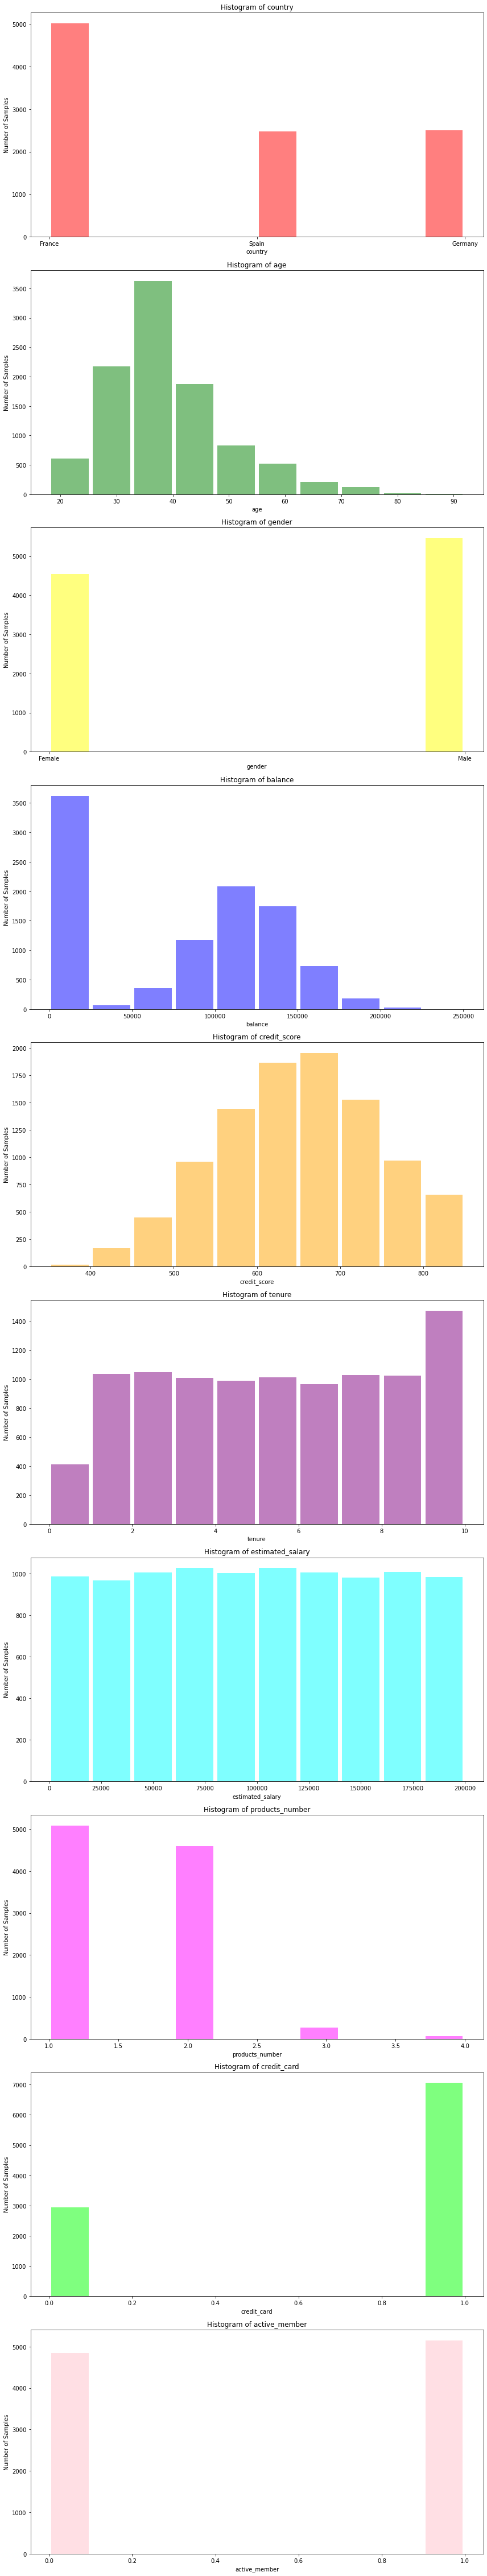

In [8]:
columns_list = ['country', 'age', 'gender', 'balance', 'credit_score', 'tenure',
                   'estimated_salary', 'products_number', 'credit_card', 'active_member']

# specify histogram parameters
colors = ['red', 'green', 'yellow', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink']
alpha = 0.5
histtype = 'bar'

# create subplots
fig, axs = plt.subplots(len(columns_list), figsize = (12, 63))

# plot each column on a separate subplot
for i, column in enumerate(columns_list):
    axs[i].hist(data[column], color=colors[i], alpha=alpha, rwidth = 0.9, histtype=histtype)
    axs[i].set_title('Histogram of {}'.format(column))
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Number of Samples')

# adjust the spacing between subplots
fig.tight_layout()

# display the plot
plt.show()

**Important things to notice**:  

* We can see that many entries of the **balance** column are zero. These can be seen as missing data, but I'm going to assume for the rest of the analysis that these are regular data, since it's not unusual to have an empty bank account;  
* The **estimated_salary** seems to follow a Uniform Distribution between 0 and 200,000;
* The **country** column only takes three value, *Spain*, *Germany* and *France*, with the latter appearing in 50% of the samples;

Now let's see the distribution of the target variable.

<AxesSubplot:ylabel='churn'>

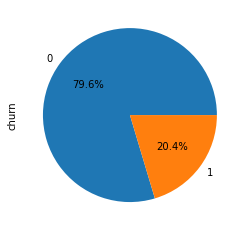

In [9]:
data['churn'].value_counts().plot(kind = 'pie', autopct='%1.1f%%')

As we can see the Churn column is highly unbalanced, since only 20% of the samples result in a positive value; we'll need to take this fact into account when training our model.  
Now let's see how the distribution of the variables changes if we take only positive samples or only negative samples:

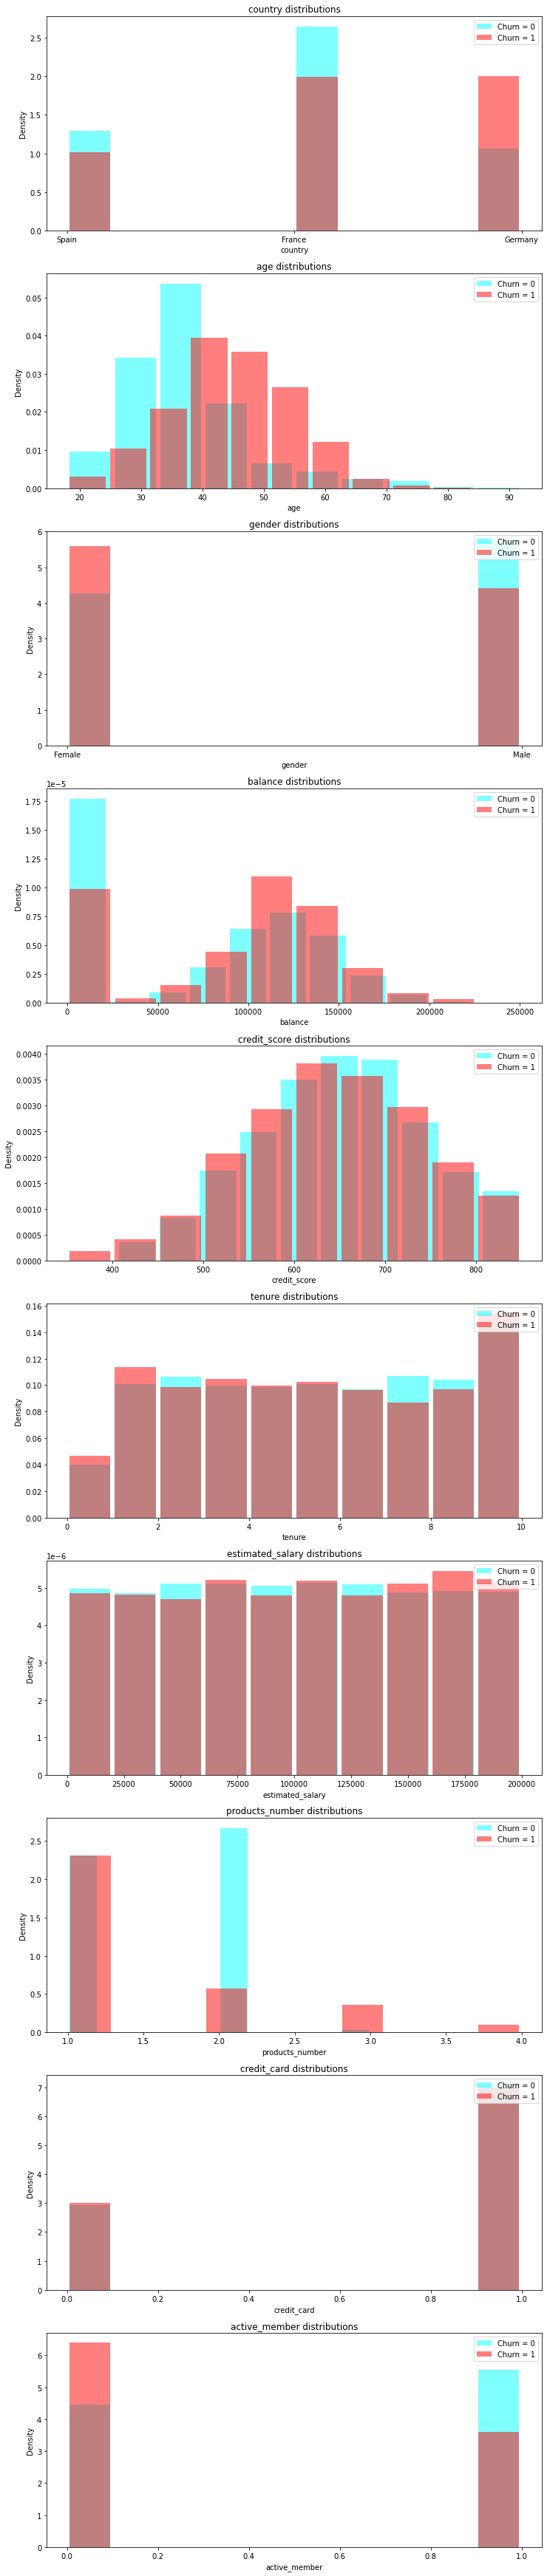

In [10]:
#split the dataset
data0 = data[data.churn == 0]
data1 = data[data.churn == 1]

fig, axs = plt.subplots(len(columns_list), figsize = (12, 63))
for i, column in enumerate(columns_list):
    '''since the churn column isn't balanced, I'm going to set the density parameter as True, so that the area under
    the two histograms are the same, and the differences in the distributions are clearer'''
    axs[i].hist(data0[column], color='cyan', alpha=alpha, rwidth = 0.9, histtype=histtype, label = 'Churn = 0', density = True)
    axs[i].hist(data1[column], color='red', alpha=alpha, rwidth = 0.9, histtype=histtype, label = 'Churn = 1', density = True)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Density')
    axs[i].set_title(f'{column} distributions')
    axs[i].legend(loc='upper right')

# display the plot
plt.show()

Let's also run some statistical tests to compare the distributions of the features in the two cases. I'm going to use the Kolmogorov-Smirnov test, and check for its p-value (a low p-value indicates that the two distributions are probably different):

In [11]:
for column in columns_list:
    pvalue = scipy.stats.ks_2samp(data0[column], data1[column], alternative='two-sided', mode='auto').pvalue
    print(f"The p-value calculated by the ks_2samp test for the {column} column is: {pvalue}")

The p-value calculated by the ks_2samp test for the country column is: 1.8047834014928533e-24
The p-value calculated by the ks_2samp test for the age column is: 3.375937672744911e-07
The p-value calculated by the ks_2samp test for the gender column is: 5.529210410894348e-25
The p-value calculated by the ks_2samp test for the balance column is: 4.3041051216750126e-32
The p-value calculated by the ks_2samp test for the credit_score column is: 0.030059908312212613
The p-value calculated by the ks_2samp test for the tenure column is: 0.5434473654076386
The p-value calculated by the ks_2samp test for the estimated_salary column is: 0.3249879927731705
The p-value calculated by the ks_2samp test for the products_number column is: 4.840830900863194e-76
The p-value calculated by the ks_2samp test for the credit_card column is: 0.9999078274538942
The p-value calculated by the ks_2samp test for the active_member column is: 8.316755520219085e-54


For most of the features the p-value is very close to zero, meaning their distribution changes if a customer churns or not.  
For **credit_score** the p-value is low, but not as low as many other features, with it being 0.03. 
For **tenure**, **estimated_salary** and **credit_card** the p-value was high so we can't say that the two distributions are different.

## 2. Modeling

Let's now build some classification models to predict if a customer churns or not.  
First let's split the dataset into a training set and a testing set, while also normalizing the columns using *Sklearn* **StandardScaler** and **LabelEncoder** for the categorical columns *country* and *gender*.

In [21]:
#import other useful libraries
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.metrics import accuracy_score,  f1_score, classification_report, confusion_matrix, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder

In [14]:
#Separate features and target columns
X = data.drop('churn', axis = 1)
y = data['churn']

#encode the labels
X['country'] = LabelEncoder().fit_transform(X['country'])
X['gender'] = LabelEncoder().fit_transform(X['gender'])

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)

#normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now to the models. Since we have an high class imbalance I'm going to use the **F1 Score** as the main metric, to keep track of which model performs the best.

#### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

In [25]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

log_pred = logreg.predict(X_test)

log_acc = accuracy_score(log_pred, y_test)
log_f1 = f1_score(log_pred, y_test)

print(f"The Accuracy on Test set for the Logistic Regression Model is: {log_acc}")
print(f"The F1 Score on Test set for the Logistic Regression Model is: {log_f1}")

The Accuracy on Test set for the Logistic Regression Model is: 0.7975
The F1 Score on Test set for the Logistic Regression Model is: 0.2401500938086304


126

In [33]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None,classifiers = 'all')
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


In [34]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.86               0.72     0.72      0.85   
AdaBoostClassifier                 0.85               0.71     0.71      0.84   
XGBClassifier                      0.85               0.71     0.71      0.84   
RandomForestClassifier             0.85               0.70     0.70      0.84   
ExtraTreesClassifier               0.85               0.70     0.70      0.84   
BaggingClassifier                  0.85               0.70     0.70      0.83   
LabelSpreading                     0.79               0.68     0.68      0.79   
LabelPropagation                   0.79               0.68     0.68      0.79   
SVC                                0.85               0.67     0.67      0.83   
NearestCentroid                    0.69               0.67     0.67      0.72   
KNeighborsClassifier        

In [60]:
import tensorflow as tf
from tensorflow.keras import callbacks

In [75]:
X_val = X_train[:2000]
y_val = y_train[:2000]
X_train = X_train[2000:]
y_train = y_train[2000:]

In [76]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
               metrics=['accuracy'])


cbs = [
    callbacks.TerminateOnNaN(),
    callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                            restore_best_weights=True, verbose=1)   
]

In [77]:
history = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks = cbs)

Epoch 1/200
188/188 [==============================] - 1s 2ms/step - loss: 0.4390 - accuracy: 0.8170 - val_loss: 0.4174 - val_accuracy: 0.8335
Epoch 2/200
188/188 [==============================] - 0s 1ms/step - loss: 0.3743 - accuracy: 0.8468 - val_loss: 0.3924 - val_accuracy: 0.8460
Epoch 3/200
188/188 [==============================] - 0s 1ms/step - loss: 0.3531 - accuracy: 0.8545 - val_loss: 0.3792 - val_accuracy: 0.8495
Epoch 4/200
188/188 [==============================] - 0s 1ms/step - loss: 0.3428 - accuracy: 0.8598 - val_loss: 0.3793 - val_accuracy: 0.8475
Epoch 5/200
188/188 [==============================] - 0s 1ms/step - loss: 0.3367 - accuracy: 0.8583 - val_loss: 0.3734 - val_accuracy: 0.8525
Epoch 6/200
188/188 [==============================] - 0s 1ms/step - loss: 0.3306 - accuracy: 0.8612 - val_loss: 0.3780 - val_accuracy: 0.8485
Epoch 7/200
188/188 [==============================] - 0s 1ms/step - loss: 0.3266 - accuracy: 0.8632 - val_loss: 0.3847 - val_accuracy: 0.8520

In [80]:
y_pred = model.predict(X_test)
test_f1 = f1_score(y_test, y_pred.round())
print(test_f1)

63/63 [==============================] - 0s 581us/step
0.6061493411420207
